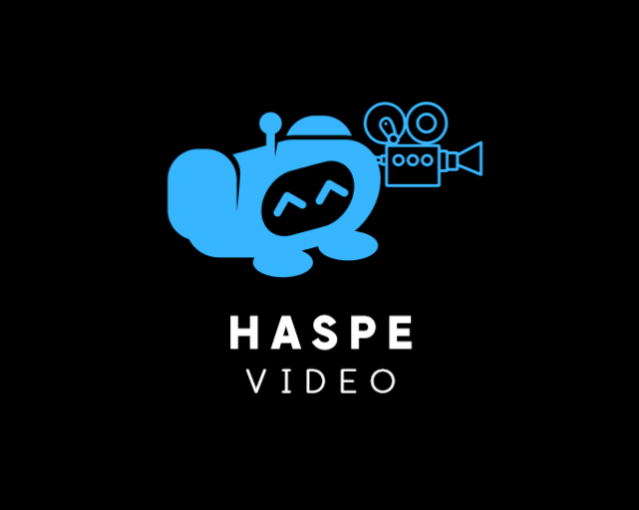

# **Installing and Importing Libraries**

In [1]:
!pip install python-telegram-bot
!pip install nest_asyncio
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install transformers
!pip install google-cloud-speech
!pip install google-cloud-videointelligence
!pip install moviepy
!pip install --upgrade ffmpeg
!pip install joblib
!pip install pytchat

In [2]:
import nest_asyncio
nest_asyncio.apply()

from typing import Final
import telegram
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes

import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from google.cloud import speech_v1
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.cloud.videointelligence_v1p3beta1.types import Feature, VideoContext, TextDetectionConfig
from google.colab import files
import pytchat
import time
import torch
import moviepy.editor as mp
import joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set Google Cloud Speech-to-Text API credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Speech Recognition/credentials1.json"
# Set Google Cloud Video Intelligence API credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Text Detection/credentials2.json"

TOKEN: Final = 'Telegram Bot API Token'
BOT_USERNAME: Final = 'Telegram Bot Username'

# **Importing the Saved Model and Definining Functions**

In [5]:
# Load the BERT model and tokenizer
model_directory = '/Hate Speech Hinglish Language/hate_speech_model'
loaded_model = TFBertForSequenceClassification.from_pretrained(model_directory)
loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

# Load the TensorFlow model
tf_model_filename = '/Hate Speech Hinglish Language/tf_model.h5'

# Load the label encoder
label_encoder_filename = '/Hate Speech Hinglish Language/label_encoder.pkl'
loaded_label_encoder = joblib.load(label_encoder_filename)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Hate Speech Detection Project/Project Execution/Backend Development/Hate Speech Detection Models/Mark 12/Saved Model/Hate Speech Hinglish Language/hate_speech_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [6]:
# Function to convert audio to text using Google Speech-to-Text
def convert_audio_to_text(audio_content):
    client = speech_v1.SpeechClient()

    config = speech_v1.RecognitionConfig(
        encoding=speech_v1.RecognitionConfig.AudioEncoding.MP3,
        sample_rate_hertz=44100,
        language_code="en-US",
        model="video",
    )

    audio = speech_v1.RecognitionAudio(content=audio_content)

    response = client.recognize(config=config, audio=audio)

    transcriptions = [result.alternatives[0].transcript for result in response.results]

    text = ' '.join(transcriptions)

    return text

# Function to predict hate speech in text
def predict_hate_speech_text(text):
    encoding = loaded_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    with tf.device('/cpu:0'):
        outputs = loaded_model.predict([input_ids, attention_mask])
        logits = outputs.logits

    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_label_id = np.argmax(probabilities)
    predicted_label = loaded_label_encoder.classes_[predicted_label_id]

    # Convert predicted_label to "Hate" or "Non-Hate"
    if predicted_label == 'yes':
        return "Hate"
    else:
        return "Non-Hate"

# Function to extract text from Video using Google Cloud Video Intelligence API
def detect_text_from_video(video_content):
    client = videointelligence.VideoIntelligenceServiceClient()

    video_bytes = io.BytesIO(video_content)

    features = [Feature.TEXT_DETECTION]

    operation = client.annotate_video(
        request={
            "input_content": video_bytes.read(),
            "features": features,
        }
    )

    result = operation.result(timeout=90)

    for annotation in result.annotation_results:
        for text_segment in annotation.text_annotations:
            detected_text = text_segment.text.strip()

    return detected_text

# Function to predict hate speech in Video with improved text extraction
def predict_hate_speech_video(video_content):
    video_text = detect_text_from_video(video_content)
    text_segments = video_text.split('\n\n')  # Split text into segments

    # Initialize a list to store results for each segment
    segment_results = []

    for segment in text_segments:
        # Predict hate speech for each segment
        segment_result = predict_hate_speech_text(segment)
        segment_results.append(segment_result)

    return segment_results

def extract_text_segments(video_content):
    client = videointelligence.VideoIntelligenceServiceClient()

    # Convert bytearray to bytes
    video_bytes = bytes(video_content)

    # Configure the request
    features = [Feature.TEXT_DETECTION]
    config = videointelligence.TextDetectionConfig(language_hints=["en"])  # Add language_hints
    context = videointelligence.VideoContext(text_detection_config=config)

    request = videointelligence.AnnotateVideoRequest(
        input_content=video_bytes,  # Pass video_bytes instead of video_content
        features=features,
        video_context=context
    )

    # Execute the request
    operation = client.annotate_video(request)  # Start long-running operation

    print("Started text detection operation. Waiting for results...")
    results = operation.result(timeout=300)  # Wait for results (with timeout)

    # Get and print results
    annotation_results = results.annotation_results[0]
    text_segments = []
    for text_annotation in annotation_results.text_annotations:
        segment_text = text_annotation.text
        text_segments.append(segment_text)

    return text_segments


# **Code for Bot 5 - Haspe Video**

In [7]:
async def start_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Hello! Thanks for chatting with me! I am the Haspe Video Bot.')

async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('I am the Haspe Video Bot! Please upload a video file so I can process it for hate speech.')

async def video_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Please upload a Video File!')

async def handle_video(update: Update, context: ContextTypes.DEFAULT_TYPE):
    if update.message.video:
        try:
            video_file = await context.bot.getFile(update.message.video.file_id)
            video_content = await video_file.download_as_bytearray()
            await update.message.reply_text('Processing your Video. Please wait...')

            # Save video content to a temporary file
            with open('/tmp/video.mp4', 'wb') as f:
                f.write(video_content)

            # Read video from temporary file
            video_clip = mp.VideoFileClip('/tmp/video.mp4')
            audio_clip = video_clip.audio

            # Save audio content to a temporary file
            audio_temp_file_path = '/tmp/audio.wav'
            audio_clip.write_audiofile(audio_temp_file_path)

            # Read audio content from temporary file
            with open(audio_temp_file_path, 'rb') as f:
                audio_content = f.read()

            # Convert audio to text
            audio_text = convert_audio_to_text(audio_content)
            audio_text = audio_text.replace('\n', ' ')

            # Predict hate speech from audio
            audio_predicted_label = predict_hate_speech_text(audio_text)

            # Extract text from video segments and predict hate speech for each segment
            text_segments = extract_text_segments(video_content)
            segment_predictions = []
            for i, segment_text in enumerate(text_segments, start=1):
                segment_predicted_label = predict_hate_speech_text(segment_text)
                segment_predictions.append((i, segment_text, segment_predicted_label))

            # Generate response message
            response_message = f'Task 1 : Audio inside Video is processed\nText Extracted from Audio inside Video : "{audio_text}"\nHate Speech Prediction for Audio inside Video : {audio_predicted_label}\n\nTask 2 : Text inside Video is processed\n'
            for segment_num, segment_text, segment_prediction in segment_predictions:
                response_message += f'Text Extracted from Video Segment {segment_num}:\n{segment_text}\nHate Speech Detection Result : {segment_prediction}\n\n'

            await update.message.reply_text(response_message)

            # Cleanup temporary files
            os.remove('/tmp/video.mp4')
            os.remove(audio_temp_file_path)
        except telegram.error.TimedOut:
            await update.message.reply_text('Downloading the video took too long. Please try again with a smaller video file or check your network connection.')
        except Exception as e:
            await update.message.reply_text(f'An error occurred: {str(e)}')
    else:
        await update.message.reply_text('The given input is not in video format. Please enter video as Input.')

def error(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print(f'Update {update} caused error {context.error}')

In [ ]:
if __name__ == '__main__':
    app = Application.builder().token(TOKEN).build()

    app.add_handler(CommandHandler('start', start_command))
    app.add_handler(CommandHandler('help', help_command))
    app.add_handler(CommandHandler('video', video_command))
    app.add_handler(MessageHandler(filters.ALL, handle_video))

    app.add_error_handler(error)

    print('Polling...')
    app.run_polling(poll_interval=3)

Polling...
